<a href="https://colab.research.google.com/github/milnico/masterAI4HU/blob/main/ESEMPIO_DI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTIAMO LE LIBRERIE
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.util import view_as_blocks
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.model_selection import KFold
from keras.utils import to_categorical


In [ ]:
np.random.seed(123)
#import dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))
print("Numero di esempi di train:",len(x_train))
print("Numero esempi di test:",len(x_test))
print("Dimensione immagini:",x_train[0].shape)
print("Numero di classi:",len(np.unique(y_train)))
print('Classes values: ', np.unique(y_train))

Numero di esempi di train: 60000
Numero esempi di test: 10000
Dimensione immagini: (28, 28)
Numero di classi: 10
Classes values:  [0 1 2 3 4 5 6 7 8 9]


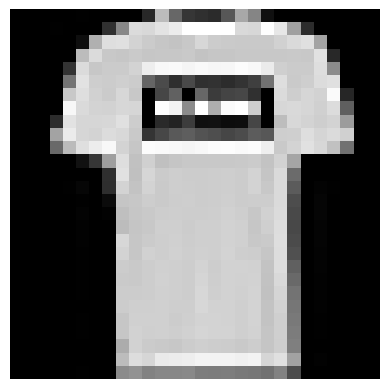

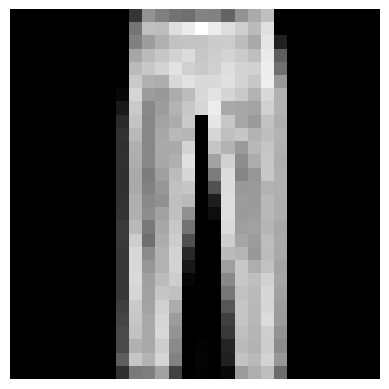

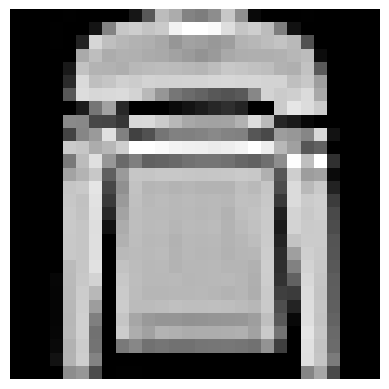

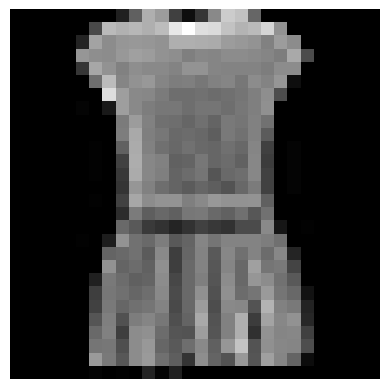

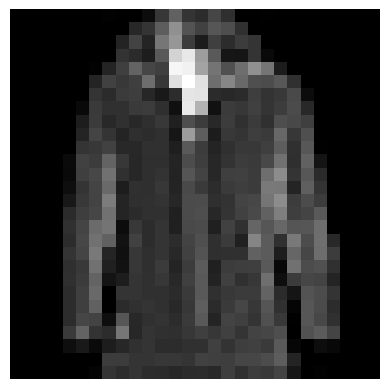

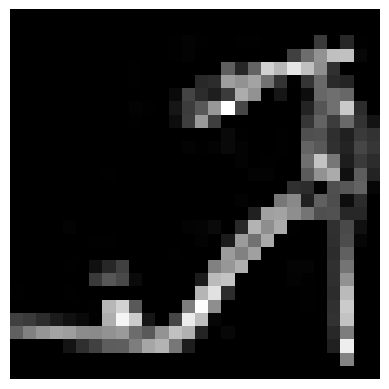

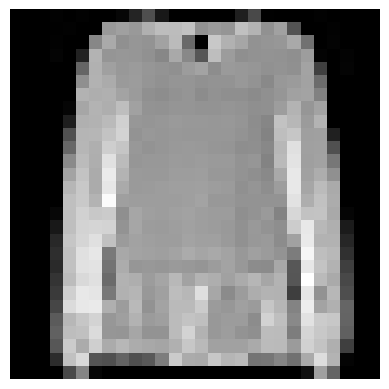

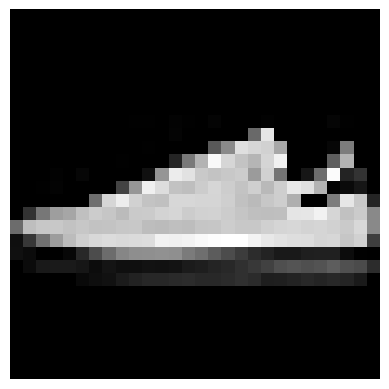

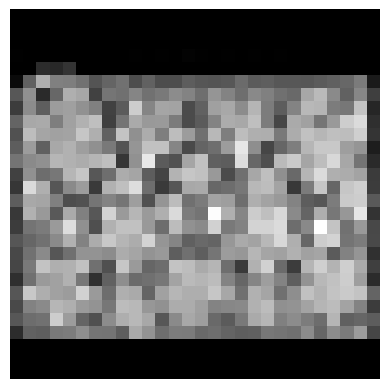

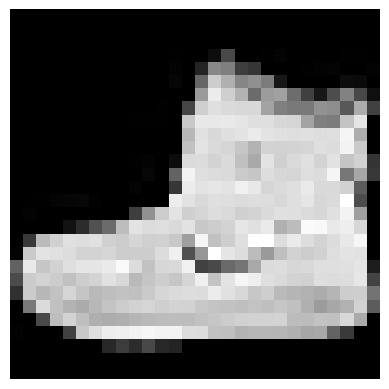

In [ ]:
#visualizziamo la prima immagine per ogni classe del train
for i in range(10):
    index=np.where(y_train==i)[0][0]
    img=x_train[index]
    plt.figure()
    plt.axis("off")
    plt.imshow(img,cmap="gray")

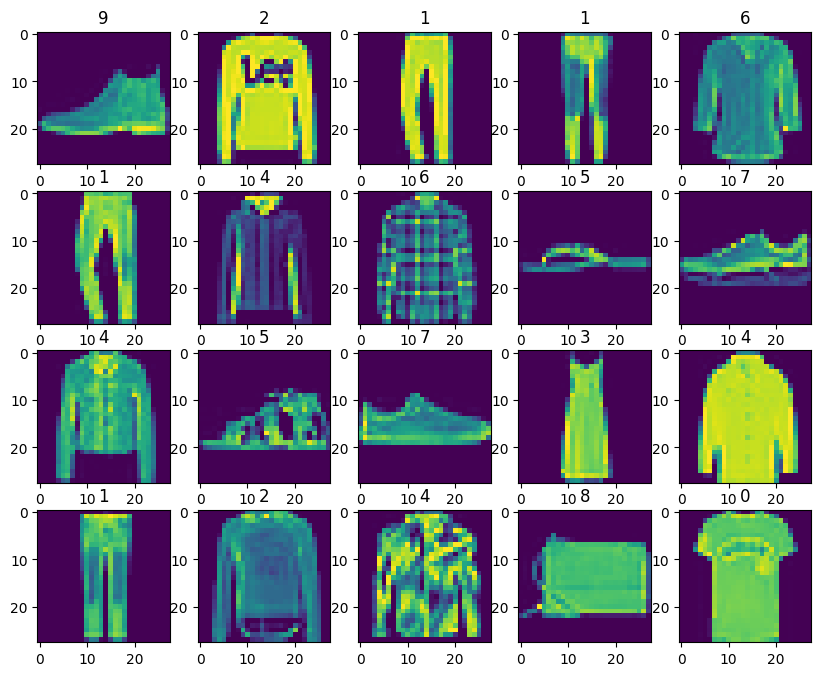

In [ ]:
#labels= ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
labels = np.unique(y_train)
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5, i+1)
    plt.imshow(x_test[i])
    plt.title( labels[(y_test[i])])

In [ ]:

#DATA STANDARDIZATION
x_train = x_train/255.
x_test = x_test/255

In [ ]:
#ONE HOT ENCODING
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Original class:', y_train[0])
print('Class converted to one-hot:', y_train[0])

Original class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Class converted to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# DEFINITION OF MODEL
def define_model():
  model = tf.keras.Sequential()
  model.add( layers.Conv2D(10, 4, input_shape=(28,28,1), activation='relu') )
  model.add(layers.MaxPooling2D(2) )#riduce le dimensioni dell'immagine mantenendo le informazioni più rilevanti,
  model.add( layers.Conv2D(32, 4, activation='relu') )
  model.add( layers.Flatten() )
  model.add( layers.Dropout(rate=0.25) )# tasso di dropout del 25%. Questo serve a prevenire l'overfitting
  model.add( layers.Dense(60, activation='relu') )
  model.add( layers.Dense(10, activation='softmax') )
  #model.summary()
  opt = keras.optimizers.Adam(learning_rate=0.001)
  #COMPILE: Configures the model for training.
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# cambiamo la forma degli array da (n, 28, 28) a (n, 28, 28, 1)
#dove n rappresenta il numero di campioni (immagini) nei set di addestramento e test.
print(np.shape(x_train))
kx_train = x_train.reshape(len(x_train,),28,28,1)
kx_test = x_test.reshape(len(x_test),28,28,1)
print(np.shape(kx_train))

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
#TEST NEURAL NETWORK
models= define_model()
training_history=models.fit(kx_train, y_train,validation_data=(kx_test,y_test), verbose=1, batch_size=50, epochs=15)#ADDESTRAMENTO
loss,accuracy=  models.evaluate(kx_test,y_test, verbose=1)#VALUTARE

#PREDICT: Generates output predictions for the input samples.
preds = models.predict(kx_test) #PREDIRE
pred_clothing  = np.argmax(preds, axis=1)
y_clothing  = np.argmax(y_test, axis=1)
#Count of miscalssed
misclassed=np.where(pred_clothing !=y_clothing,1,0)



Epoch 1/15
1200/1200 [==============================] - 18s 6ms/step - loss: 0.4994 - accuracy: 0.8191 - val_loss: 0.3773 - val_accuracy: 0.8627
Epoch 2/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.3361 - accuracy: 0.8772 - val_loss: 0.3404 - val_accuracy: 0.8774
Epoch 3/15
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2919 - accuracy: 0.8921 - val_loss: 0.2901 - val_accuracy: 0.8942
Epoch 4/15
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2642 - accuracy: 0.9019 - val_loss: 0.2899 - val_accuracy: 0.8970
Epoch 5/15
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2435 - accuracy: 0.9098 - val_loss: 0.2708 - val_accuracy: 0.9042
Epoch 6/15
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2277 - accuracy: 0.9151 - val_loss: 0.2631 - val_accuracy: 0.9038
Epoch 7/15
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2120 - accuracy: 0.9212 - val_loss: 0.2644 - val_accuracy

In [ ]:
print("TEST LOSS",round(loss,1),"TEST ACCURACY", round(accuracy,1),"Number of misclassified clothing :" , np.count_nonzero(misclassed))

TEST LOSS 0.3 TEST ACCURACY 0.9 Number of misclassified clothing : 874


In [ ]:
#CROSS VALIDATION
kf = KFold(n_splits=5)
kf.get_n_splits(kx_train)

fold_count = 0
cvscores=[]
histories=[]
best_accuracy=[]

for train_ix,test_ix in kf.split(kx_train):

  train_x, train_y, test_x, test_y = kx_train[train_ix], y_train[train_ix], kx_train[test_ix], y_train[test_ix]
  model = tf.keras.Sequential()
  model.add( layers.Conv2D(10, 4, input_shape=(28,28,1), activation='relu') )
  model.add(layers.MaxPooling2D(2) )
  model.add( layers.Conv2D(32, 4, activation='relu') )
  model.add( layers.Flatten() )
  model.add( layers.Dropout(rate=0.25) )
  model.add( layers.Dense(60, activation='relu') )
  model.add( layers.Dense(10, activation='softmax') )
  #model.summary()
  opt = keras.optimizers.Adam(learning_rate=0.001)
  #COMPILE: Configures the model for training.
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  #FIT: Trains the model for a fixed number of epochs (iterations on a dataset).
  history=model.fit(train_x, train_y,validation_data=(test_x,test_y),verbose=0, batch_size=50, epochs=15)
  loss_validation,accuracy_validation =  model.evaluate(test_x,test_y, verbose=0)
  cvscores.append(loss_validation)
  histories.append(history)
  best_accuracy.append(accuracy_validation )
  fold_count = fold_count + 1
  best_fold= np.amax(best_accuracy)


  print("FOLD",fold_count,': ',"VALIDATION LOSS",round(loss_validation,3), "VALIDATION ACCURACY", round(accuracy_validation,3))
print( "CROSS_VALIDATED_ERROR:",round(np.mean(cvscores)*100,2),"%")
print("BEST ACCURACY FOLD :"" ",round(best_fold*100,3),"%")

FOLD 1 :  VALIDATION LOSS 0.255 VALIDATION ACCURACY 0.915
FOLD 2 :  VALIDATION LOSS 0.289 VALIDATION ACCURACY 0.906
FOLD 3 :  VALIDATION LOSS 0.257 VALIDATION ACCURACY 0.914
FOLD 4 :  VALIDATION LOSS 0.283 VALIDATION ACCURACY 0.916
FOLD 5 :  VALIDATION LOSS 0.267 VALIDATION ACCURACY 0.911
CROSS_VALIDATED_ERROR: 27.0 %
BEST ACCURACY FOLD :  91.642 %


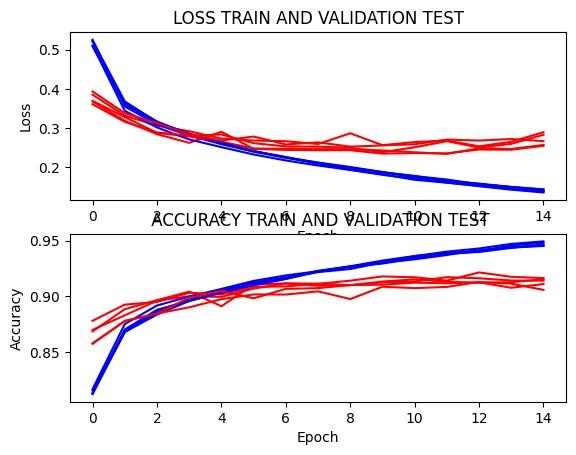

In [ ]:
# PLOT OF EVERY FOLD
for i in range(len(histories)):
	# plot loss
		plt.subplot(2,1,1)
		plt.title('LOSS TRAIN AND VALIDATION TEST')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='red', label='validation_test')
		plt.ylabel("Loss")
		plt.xlabel("Epoch")

		# plot accuracy
		plt.subplot(2,1,2)
		plt.title(' ACCURACY TRAIN AND VALIDATION TEST')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='red', label='validation_test')
		plt.ylabel("Accuracy")
		plt.xlabel("Epoch")
plt.show()